# Project 2: Backtester

## Overview

In this project, I am building a simple backtesting framework to test a classic technical trading strategy: the moving average crossover. The idea is to use a fast-moving average and a slow-moving average to identify trends in asset prices. When the fast MA rises above the slow MA, the strategy goes long; otherwise, it stays out of the market or goes short. We can then compare this strategy against buy-and-hold and RSI and Bollinger strategies.

---

## Features

- Loading and preparing price data with yfinance
- Generating trading signals
- Translating signals into positions and computing returns
- Accounting for simple transaction costs
- Comparing strategy performance against buy-and-hold
- Evaluating performance using annualised return, volatility, Sharpe ratio, and max drawdown
- Exploring how results vary across different strategies (RSI and Bollinger)

---

I will start by reading prices for MSFT, TSLA, and NVDA and defining the idea. A moving average crossover tries to catch trends, where a fast MA follows price closely and a slow MA is smoother.

When fast > slow there is an uptrend so we go long; otherwise we don't trade or short. Signals will be generated where +1 means long, -1 short, and 0 flat. 

To avoid look ahead bias, we shift the signal by one day as today's trade must be based on information available at yesterday's close.

Once the signals have been turned into positions, we can calculate the returns and add transaction costs (1% assumed).

We can also visualise the entries and exits on a plot for each ticker of interest.

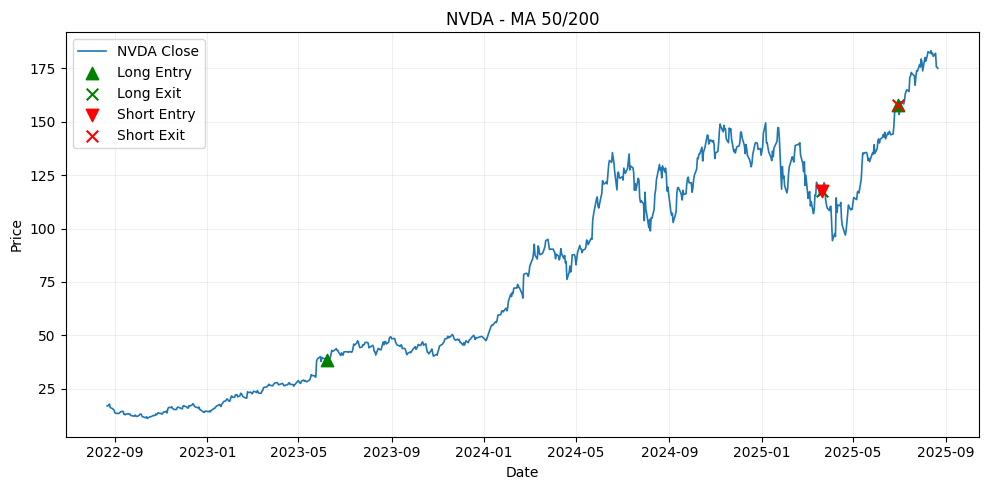

In [349]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

TICKERS = "MSFT", "TSLA", "NVDA"
PERIOD = "3y"

px = yf.download(TICKERS, period=PERIOD, interval="1d", auto_adjust=True, progress=False)["Close"]
px = px.ffill().dropna()

fast = 50
slow = 200

ma_fast = px.rolling(fast, min_periods=fast).mean()
ma_slow = px.rolling(slow, min_periods=slow).mean()

signal = np.where(ma_fast > ma_slow, 1.0, np.where(ma_fast < ma_slow, -1.0, 0.0))
signal = pd.DataFrame(signal, index=px.index, columns=px.columns)

positions = pd.DataFrame(index=px.index, columns=px.columns)
positions_exec = signal.shift(1).fillna(0.0)

rets = px.pct_change().fillna(0.0)
per_asset_pnl = positions_exec * rets
gross = per_asset_pnl.mean(axis=1)

bps_cost = 1/10000

turnover = positions_exec.diff().abs().mean(axis=1).fillna(0.0)
costs = turnover * bps_cost
net = gross - costs

def trades_to_positions(positions_exec: pd.DataFrame, ticker: str):
    pos = positions_exec[ticker].fillna(0.0)
    prev = pos.shift(1).fillna(0.0)
    
    long_entry = (prev <= 0) & (pos > 0)
    long_exit = (prev > 0) & (pos <= 0)
    
    short_entry = (prev >= 0) & (pos < 0)
    short_exit = (prev < 0) & (pos >= 0)
    
    return long_entry, long_exit, short_entry, short_exit

def plot_price_with_signals (px: pd. DataFrame, positions_exec: pd.DataFrame, ticker: str, title=None):
    price = px[ticker].dropna()
    le, lx, se, sx = trades_to_positions(positions_exec, ticker)
    
    plt.figure(figsize=(10,5))
    plt.plot(price.index, price.values, label=f"{ticker} Close", linewidth = 1.2)
    
    plt.scatter(price.index[le], price[le], marker="^", s=80, color="green", label="Long Entry", zorder=3)
    plt.scatter(price.index[lx], price[lx], marker="x", s=70, color="green", label="Long Exit", zorder=3)
    plt.scatter(price.index[se], price[se], marker="v", s=80, color="red", label="Short Entry", zorder=3)
    plt.scatter(price.index[sx], price[sx], marker="x", s=70, color="red", label="Short Exit", zorder=3)
    
    plt.title(title or "Price with Buy/Sell Signals (Executed)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc = "best")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
    
plot_price_with_signals(px, positions_exec,  ticker = "NVDA", title = f"NVDA - MA {fast}/{slow}")

---

Now we want to turn returns from the MA strategy into equity curves to show compounding and provide metrics that summarise performance and risk. These metrics are Annualised Compount Return, Annualised Volatility, Sharpe Ratio, Max Drawdown, Exposure, Hit Rate, and Average Holding Period in Days.

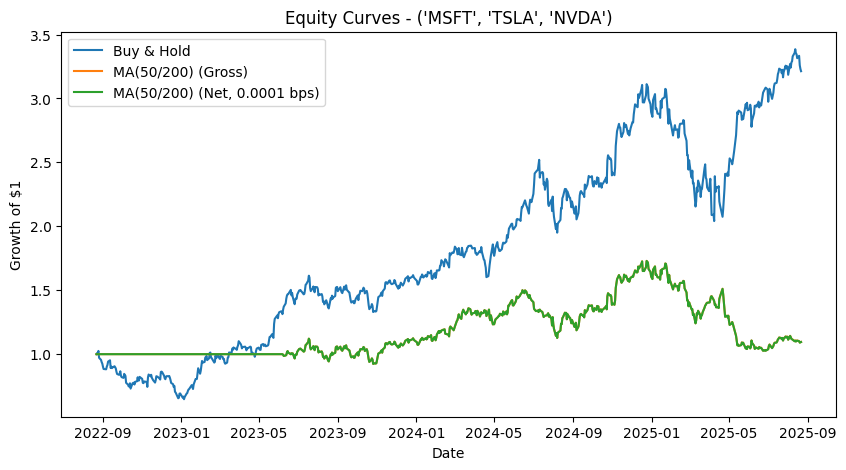

Ann.Return        0.030809
Ann.Vol           0.264497
Sharpe            0.116481
Max.DD           -0.406432
Avg.Turnover      0.011952
Exposure          0.734396
Hit Rate          0.394422
Hold.Days       553.000000
Name: MA 50/200, dtype: float64


In [350]:
buyhold = (1 + rets.mean(axis=1)).cumprod()
eq_gross = (1 + gross).cumprod()
eq_et = (1 + net).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(buyhold.index, buyhold, label="Buy & Hold")
plt.plot(eq_gross.index, eq_gross, label=f"MA({fast}/{slow}) (Gross)")
plt.plot(eq_et.index, eq_et, label=f"MA({fast}/{slow}) (Net, {bps_cost} bps)")
plt.title(f"Equity Curves - {TICKERS}")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.show()

def ann_return(daily_rets: pd.Series) -> float:
    n = daily_rets.shape[0]
    if n == 0: return np.nan
    return (1 + daily_rets).prod() ** (252 / n) - 1

def ann_vol(daily_rets:pd.Series) -> float:
    return daily_rets.std() * np.sqrt(252)

def sharpe(daily_rets: pd.Series) -> float:
    vol = ann_vol(daily_rets)
    return np.nan if vol == 0 or np.isnan(vol) else ann_return(daily_rets) / vol

def max_drawdown(equity: pd.Series) -> float:
    roll_max = equity.cummax()
    dd = equity / roll_max - 1
    return dd.min()

def exposure(positions: pd.DataFrame) -> float:
    return positions.abs().mean().mean()

def hit_rate(daily_rets: pd.Series) -> float:
    return (daily_rets > 0).mean()

def avg_holding_period(positions: pd.DataFrame) -> float:
    lens = []
    for col in positions:
        s = positions[col].fillna(0).astype(float)
        runs = (s == 0).astype(int).diff().ne(0)
        seg_id = runs.cumsum()
        for _, seg in s.groupby(seg_id):
            if seg.iloc[0] != 0:
                lens.append(len(seg))
    return np.mean(lens) if lens else np.nan

def summarise_metrics(name: str, daily_rets: pd.Series, positions: pd.DataFrame):
    eq = (1 + net).cumprod()

    return pd.Series({
        "Ann.Return": ann_return(net),
        "Ann.Vol": ann_vol(net),
        "Sharpe": sharpe(net),
        "Max.DD": max_drawdown(eq),
        "Avg.Turnover": turnover.mean(),
        "Exposure": exposure(positions),
        "Hit Rate": hit_rate(net),
        "Hold.Days": avg_holding_period(positions_exec)
    }, name = name)

metrics = summarise_metrics(f"MA {fast}/{slow}", net, positions_exec)
print(metrics)

---
Next, I want to compare the MA strategy to two widely used mean-reversion approaches. The Relative Strength Index (RSI) and and Bollinger Bands. We used MA Crossover as it is trend-folliwing and captures prolonged directional moves. Now we will be using mean reversion strategies which seek to profit from short-term price reversals.

The RSI strategy looks for overbought or oversold conditions based on momentum, going long when prices are weak and short when they are strong. The Bollinger Bands strategy uses price deviations from a moving average, taking trades when prices move outside the bands with the expecation they will revert back.

By comparing these three strategies, we can evaluate how different trading styles behave in terms of returns, risks, and costs.

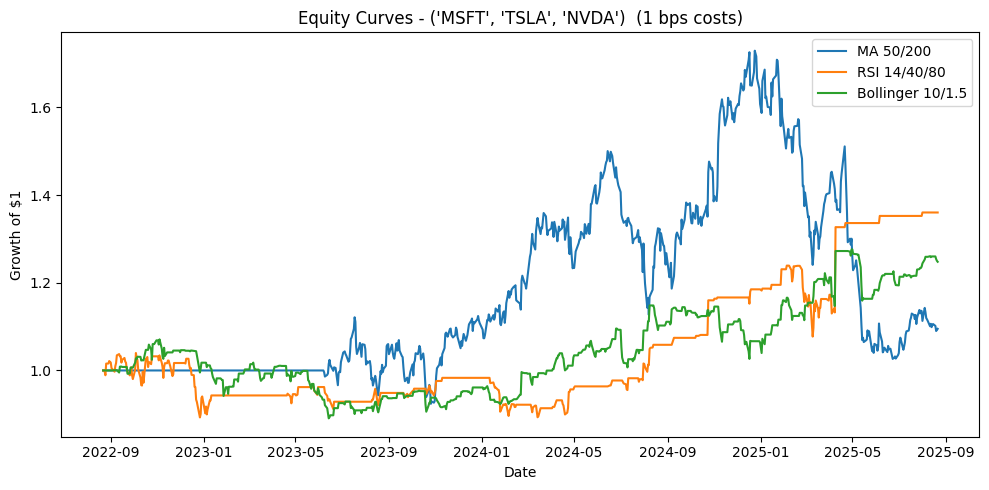

               MA 50/200  RSI 14/40/80  Bollinger 10/1.5
Ann.Return      0.030809      0.108450          0.076915
Ann.Vol         0.264497      0.176945          0.152396
Sharpe          0.116481      0.612899          0.504706
Max.DD         -0.406432     -0.141346         -0.168185
Avg.Turnover    0.011952      0.081452          0.275343
Exposure        0.734396      0.154936          0.246127
Hit Rate        0.394422      0.167331          0.265604
Hold.Days     553.000000      3.804348          1.799353


In [351]:
rsi_period = 14
rsi_lower = 40
rsi_upper= 80
boll_window = 10
boll_nstd = 1.5

def rsi(prices: pd.DataFrame, period: int) -> pd.DataFrame:
    ret = prices.pct_change()
    up = ret.clip(lower=0)
    down = -ret.clip(upper=0)
    roll_up = up.ewm(alpha=1/period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/period, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-12)
    return 100 - (100/(1+rs))

def rsi_strategy(prices: pd.DataFrame, period, lower, upper) -> pd.DataFrame:
    r =rsi(prices, period)
    long = (r<lower).astype(float)
    short = (r>upper).astype(float)
    sig = long - short
    return sig.fillna(0.0) 

def bollinger_strategy(prices: pd.DataFrame, window, n_std) -> pd.DataFrame:
    ma = prices.rolling(window, min_periods=window).mean()
    std = prices.rolling(window, min_periods=window).std()
    upper = ma + n_std * std
    lower = ma - n_std * std
    long = (prices < lower).astype(float)
    short = (prices > upper).astype(float)
    sig = long - short
    return sig.fillna(0.0)

def run_strategy(name: str, signal: pd.DataFrame, rets: pd.DataFrame, bps_cost: float = 1/10000):
    positions_exec = signal.shift(1).fillna(0.0)
    
    per_asset_pnl = positions_exec * rets
    gross = per_asset_pnl.mean(axis=1)
    
    turnover = positions_exec.diff().abs().mean(axis=1).fillna(0.0)
    costs = turnover * bps_cost
    net = gross - costs
    
    return name, net, positions_exec, gross, turnover, costs

ma_fast = px.rolling(fast, min_periods=fast).mean()
ma_slow = px.rolling(slow, min_periods=slow).mean()
ma_sig = np.where(ma_fast > ma_slow, 1.0, np.where(ma_fast < ma_slow, -1.0, 0.0))
ma_sig = pd.DataFrame(ma_sig, index=px.index, columns=px.columns)

rsi_sig  = rsi_strategy(px, period=(rsi_period), lower=(rsi_lower), upper=(rsi_upper))  
boll_sig = bollinger_strategy(px, window=(boll_window), n_std=(boll_nstd))

ma_name,   ma_net,   ma_pos,   ma_gross,   ma_turn,   ma_costs   = run_strategy(f"MA {fast}/{slow}", ma_sig,   rets, bps_cost)
rsi_name,  rsi_net,  rsi_pos,  rsi_gross,  rsi_turn,  rsi_costs  = run_strategy(f"RSI {rsi_period}/{rsi_lower}/{rsi_upper}",       rsi_sig,  rets, bps_cost)
boll_name, boll_net, boll_pos, boll_gross, boll_turn, boll_costs = run_strategy(f"Bollinger {boll_window}/{boll_nstd}",          boll_sig, rets, bps_cost)

plt.figure(figsize=(10, 5))
plt.plot((1 + ma_net).cumprod(),   label=ma_name)
plt.plot((1 + rsi_net).cumprod(),  label=rsi_name)
plt.plot((1 + boll_net).cumprod(), label=boll_name)
plt.title(f"Equity Curves - {TICKERS}  ({int(bps_cost*10_000)} bps costs)")
plt.xlabel("Date"); plt.ylabel("Growth of $1")
plt.legend(); plt.tight_layout(); plt.show()

def summarise_metrics(name: str, daily_rets: pd.Series, positions_exec: pd.DataFrame, turnover: pd.Series) -> pd.Series:
    eq = (1 + daily_rets).cumprod()
    return pd.Series({
        "Ann.Return": ann_return(daily_rets),
        "Ann.Vol": ann_vol(daily_rets),
        "Sharpe": sharpe(daily_rets),
        "Max.DD": max_drawdown(eq),
        "Avg.Turnover": turnover.mean(),
        "Exposure": exposure(positions_exec),
        "Hit Rate": hit_rate(daily_rets),
        "Hold.Days": avg_holding_period(positions_exec),
    }, name=name)
    
metrics_table = pd.concat([
    summarise_metrics(ma_name,   ma_net,   ma_pos,   ma_turn),
    summarise_metrics(rsi_name,  rsi_net,  rsi_pos,  rsi_turn),
    summarise_metrics(boll_name, boll_net, boll_pos, boll_turn),
], axis=1)

print(metrics_table)

---

So far, our three strategies have used simple binary positions:
- +1 when long
- -1 when short
- 0 when flat

This is unrealistic as in practice, traders adjust how much capital to allocate based on risk and conviction. We will now implement position sizing which aims to control exposure so that portfolio risk is mananged and returns are more efficient. There are two classic approaches:
- Volatility Targeting: Scales positions so the portfolio runs at a chosen annualised volatility (12%). This smooths the equity curve and makes risk comparable across assets.
- Kelly Sizing: Allocates according to expected return relative to variance $\frac{\mu}{{\sigma}^2}$. This is the theoretical growth-optimal fraction, though in practice it must be capped to avoid over-betting.

By applying these sizers to our raw signals, we'll see how Sharpe ratios, drawdowns, and turnover change compared to the "all-in" baseline strategies.

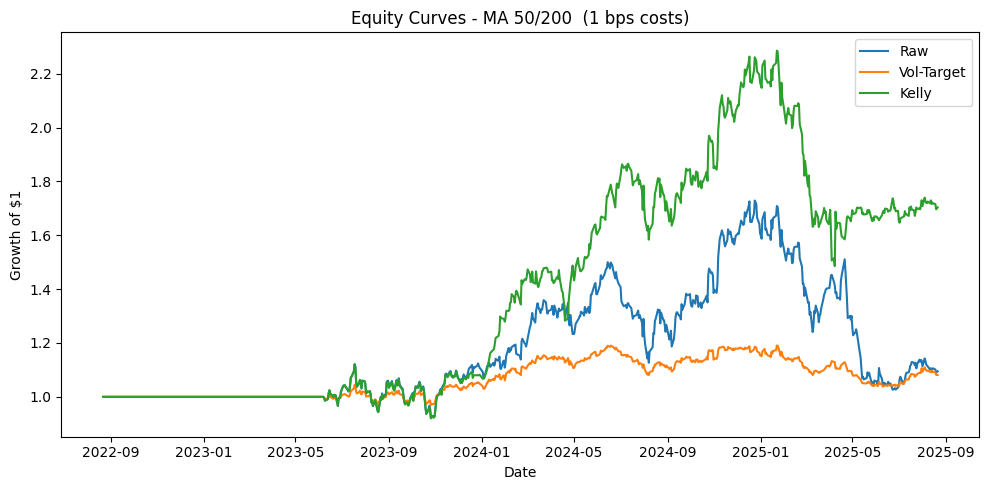

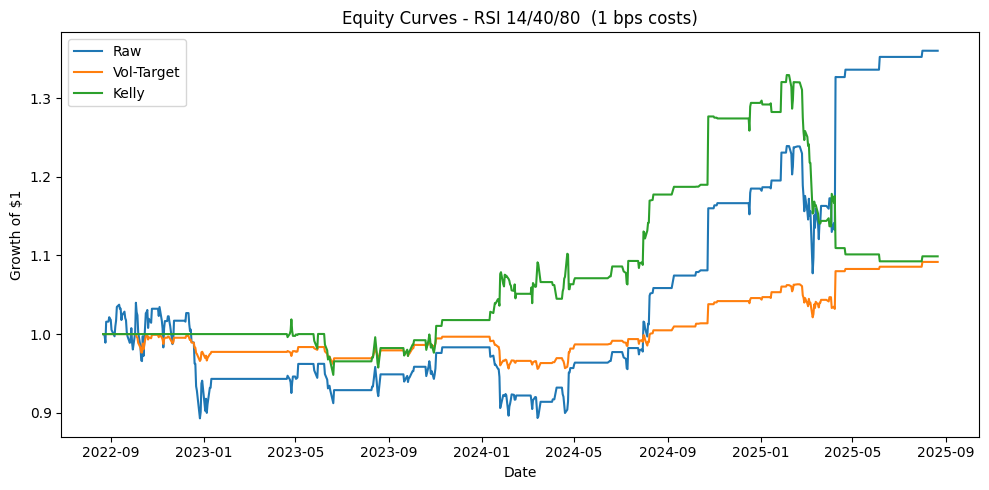

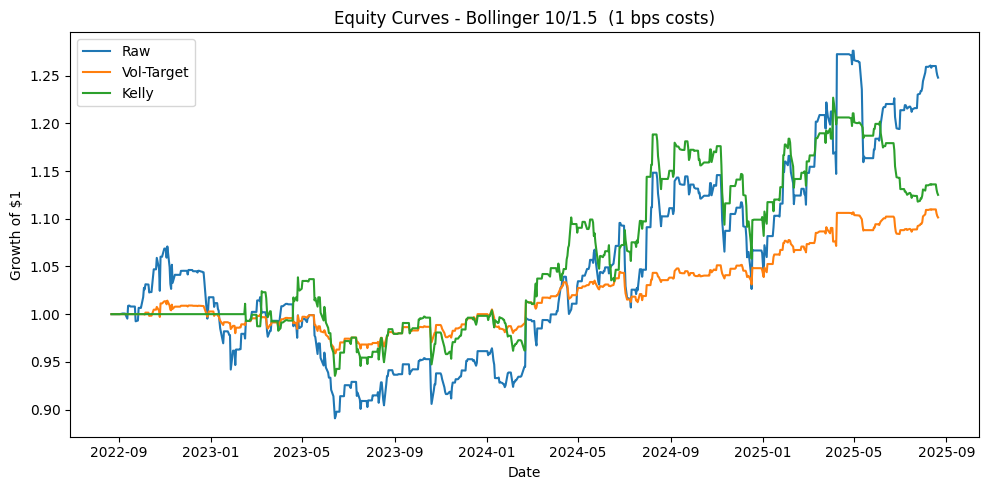

                               Ann.Return   Ann.Vol    Sharpe    Max.DD  \
MA 50/200 - Raw                  0.030809  0.264497  0.116481 -0.406432   
MA 50/200 - Vol-Target           0.026533  0.094684  0.280223 -0.128126   
MA 50/200 - Kelly                0.195177  0.256322  0.761451 -0.350031   
RSI 14/40/80 - Raw               0.108450  0.176945  0.612899 -0.141346   
RSI 14/40/80 - Vol-Target        0.029808  0.051817  0.575248 -0.044224   
RSI 14/40/80 - Kelly             0.032045  0.107172  0.299003 -0.178189   
Bollinger 10/1.5 - Raw           0.076915  0.152396  0.504706 -0.168185   
Bollinger 10/1.5 - Vol-Target    0.032830  0.049602  0.661875 -0.054541   
Bollinger 10/1.5 - Kelly         0.040210  0.114767  0.350365 -0.109672   

                               Avg.Turnover  Exposure  Hit Rate   Hold.Days  
MA 50/200 - Raw                    0.011952  0.734396  0.394422  553.000000  
MA 50/200 - Vol-Target             0.013813  0.329623  0.382470  553.000000  
MA 50/200 - Kel

In [352]:
def vol_target_sizer(prices: pd.DataFrame, raw_positions: pd.DataFrame, target_ann_vol, lookback,max_leverage):
    rets = prices.pct_change()
    rolling_vol = rets.rolling(lookback).std()*np.sqrt(252)
    k = (target_ann_vol / (rolling_vol + 1e-8)).clip(upper=max_leverage)
    sized = raw_positions*k
    return sized.fillna(0.0).clip(-max_leverage, max_leverage)

def kelly_sizer(prices: pd.DataFrame, raw_positions:  pd.DataFrame, lookback, max_f):
    rets = prices.pct_change()
    mu = rets.rolling(lookback).mean()
    var = rets.rolling(lookback).var()
    f = (mu / (var + 1e-12)).clip(lower=-max_f,upper=max_f)
    sized = raw_positions * f
    return sized.fillna(0.0)

def run_strategy(name: str, signal: pd.DataFrame, rets: pd.DataFrame, bps_cost: float = 1/10000, sizer=None):
    raw_pos = signal.copy()

    if sizer is not None:
        raw_pos = sizer(px, raw_pos)

    positions_exec = raw_pos.shift(1).fillna(0.0)

    per_asset_pnl = positions_exec * rets
    gross = per_asset_pnl.mean(axis=1)

    turnover = positions_exec.diff().abs().mean(axis=1).fillna(0.0)
    costs = turnover * bps_cost
    net = gross - costs

    return name, net, positions_exec, gross, turnover, costs

strategies = [
    (f"MA {fast}/{slow}", ma_sig),
    (f"RSI {rsi_period}/{rsi_lower}/{rsi_upper}", rsi_sig),
    (f"Bollinger {boll_window}/{boll_nstd}", boll_sig),
]

sizers = {
    "Raw": None,
    "Vol-Target": lambda _px, sig: vol_target_sizer(_px, sig, target_ann_vol=0.15, lookback=30, max_leverage=3.0),
    "Kelly":      lambda _px, sig: kelly_sizer(_px, sig, lookback=120, max_f=1.0),
}

results = {}        
metrics_rows = []    

for strat_name, sig in strategies:
    for variant, sizer_fn in sizers.items():
        name, net, pos, gross, turn, costs = run_strategy(
            f"{strat_name} - {variant}", sig, rets, bps_cost, sizer=sizer_fn
        )
        metrics_rows.append(summarise_metrics(name, net, pos, turn))
        results[(strat_name, variant)] = {"net": net, "pos": pos, "turn": turn}

for strat_name, _ in strategies:
    plt.figure(figsize=(10, 5))
    for variant in ["Raw", "Vol-Target", "Kelly"]:
        net = results[(strat_name, variant)]["net"]
        plt.plot((1 + net).cumprod(), label=variant)
    plt.title(f"Equity Curves - {strat_name}  ({int(bps_cost*10_000)} bps costs)")
    plt.xlabel("Date"); plt.ylabel("Growth of $1")
    plt.legend(); plt.tight_layout(); plt.show()

metrics_table = pd.concat(metrics_rows, axis=1).T
print(metrics_table)

---
## Summary

- We tested three technical strategies: Moving Average 50/200, RSI(14/40/80), and Bollinger(10/1.5) across MSFT, TSLA, and NVDA over 3 years.

Each was run under three position sizing schemes:
- Raw: binary ±1 positions.
- Vol-Target: scaled to 15% annualised volatility (30-day lookback).
- Kelly: sized by μ/σ² with 120-day lookback, capped at 1.0× leverage.

Transaction costs were set to 1 bps per turnover.

---
## Findings

1. Raw strategies
-MA 50/200:
 Always invested (~73% exposure), long holding periods (~553 days).
 Return ~3%, Sharpe 0.12, drawdown −40%.
 Stable, but weak efficiency.
-RSI 14/40/80:
 - Return ~11%, Sharpe ~0.61.
 - Exposure low (~15%), holding periods very short (3–4 days).
 - More efficient than MA, but highly sensitive to turnover/costs.
-Bollinger 10/1.5:
 - Return ~7.7%, Sharpe ~0.50.
 - High turnover (0.27), holding periods ~2 days.
 Intermediate between MA and RSI.

2. Vol-target sizing (15% target, 30-day lookback)
- Dramatically reduced annual volatility (to ~10%).
- Sharpe improved across strategies (e.g. Bollinger raw 0.50 → vol-target 0.66).
- Returns fell in nominal terms but risk-adjusted efficiency rose.
- Exposure increased vs raw for mean-reversion strategies, smoothing equity curves.
- Costs rose slightly from rebalancing, but manageable.

3. Kelly sizing (120-day lookback, cap = 1.0)
- Amplified returns significantly (e.g. MA 50/200 raw 3% → Kelly 19%).
- Higher volatility and deeper drawdowns, but Sharpe improved in some cases.
- For RSI, Kelly was unstable: drawdowns worsened and Sharpe dropped.
- Bollinger Kelly produced more return but lower Sharpe vs vol-target.
- Kelly sizing is fragile: heavily dependent on lookback, unstable for short mean-reversion signals.

Visual Insights
- MA 50/200: Kelly sizing unlocked strong growth but exposed large swings; vol-target produced the smoothest curve.
- RSI: Raw and vol-target showed step-like equity curves; Kelly magnified both gains and losses.
- Bollinger: Vol-target gave the cleanest improvement, while Kelly often overshot.

In conclusion, Vol-targeting at 10–15% provided the most consistent improvement across all strategies (higher Sharpe, lower drawdowns, smoother equity). Kelly boosted returns but introduced instability, especially for fast-turnover strategies (RSI, Bollinger). Raw sizing is simple but leaves portfolios either under-risked (RSI) or inefficient (MA).

---
## Next Steps

1. Robustness checks
- Try other vol targets (10%, 20%) and Kelly caps (0.5×, 0.25×).
- Test on different tickers or longer history.

2. Walk-forward / OOS validation
- Select parameters (fast/slow, RSI thresholds, Boll bands) in a train window, then test OOS.

3. Portfolio weighting
- Instead of equal-weighting across assets, test inverse-volatility weighting or correlation-adjusted risk parity.

4. Slippage & higher costs
- Re-run at 5-10 bps cost levels to measure cost sensitivity.

5. Advanced sizing
- Combine vol-target + fractional Kelly for balanced growth.
- Add drawdown-based sizing (reduce exposure in stress).